In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
df = pd.read_json(r'C:\Users\Linds\Repos\East_River\Data\Raw\DSU_wx_history_redo.json')
print(df.head())

                 SELECT *\r\nFROM er_test.wx_history
0  {'location': 'Aberdeen, South Dakota', 'obs_tm...
1  {'location': 'Alsville, South Dakota', 'obs_tm...
2  {'location': 'Ames, South Dakota', 'obs_tms_lc...
3  {'location': 'Andover, South Dakota', 'obs_tms...
4  {'location': 'Arco, Minnesota', 'obs_tms_lcl':...


In [3]:
# Display dataframe information
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6084216 entries, 0 to 6084215
Data columns (total 1 columns):
 #   Column                             Dtype 
---  ------                             ----- 
 0   SELECT *
FROM er_test.wx_history  object
dtypes: object(1)
memory usage: 46.4+ MB


In [4]:

# create a new DataFrame with separate columns by normalizing the JSON data.
df_parsed = pd.json_normalize(df.iloc[:, 0])
print(df_parsed.head())

                 location               obs_tms_lcl  temperature  wind_speed  \
0  Aberdeen, South Dakota  2020-12-31T06:00:00.000Z           12           7   
1  Alsville, South Dakota  2020-12-31T06:00:00.000Z            5           5   
2      Ames, South Dakota  2020-12-31T06:00:00.000Z           16           7   
3   Andover, South Dakota  2020-12-31T06:00:00.000Z           12           7   
4         Arco, Minnesota  2020-12-31T06:00:00.000Z            7           6   

   wind_degree wind_dir weather_descriptions  precip  humidity  visibility  \
0          197      SSW               Cloudy     0.0        90           6   
1          206      SSW               Cloudy     0.0        86           6   
2          165      SSE                Clear     0.0        84           6   
3          197      SSW               Cloudy     0.0        90           6   
4          228       SW               Cloudy     0.0        88           6   

   pressure  cloudcover  heatindex  dewpoint  wind

In [5]:
df_parsed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6084216 entries, 0 to 6084215
Data columns (total 18 columns):
 #   Column                Dtype  
---  ------                -----  
 0   location              object 
 1   obs_tms_lcl           object 
 2   temperature           int64  
 3   wind_speed            int64  
 4   wind_degree           int64  
 5   wind_dir              object 
 6   weather_descriptions  object 
 7   precip                float64
 8   humidity              int64  
 9   visibility            int64  
 10  pressure              float64
 11  cloudcover            int64  
 12  heatindex             int64  
 13  dewpoint              int64  
 14  windchill             int64  
 15  windgust              int64  
 16  feelslike             int64  
 17  uv_index              int64  
dtypes: float64(2), int64(12), object(4)
memory usage: 835.5+ MB


In [6]:
df_parsed['temperature'] = df_parsed['temperature'].astype(float)

In [7]:
# Identify numeric columns and convert them to float
num_cols = df_parsed.select_dtypes(include=['number']).columns
df_parsed[num_cols] = df_parsed[num_cols].astype(float)

# Upsample to a half-hour frequency and forward-fill the weather data keeping all locations


In [9]:
# Reset index to ensure all columns are available
df_parsed.reset_index(inplace=True)
# Ensure the datetime column is converted to DatetimeIndex using the appropriate column
df_parsed['datetime'] = pd.to_datetime(df_parsed['obs_tms_lcl'])

# Set a multi-level index with location and datetime
df_parsed.set_index(['location', 'datetime'], inplace=True)

# Remove duplicate indices
df_parsed = df_parsed[~df_parsed.index.duplicated(keep='first')]

# Upsample to a half-hour frequency and forward-fill the weather data
df_parsed = (
    df_parsed.groupby(level='location')
             .apply(lambda grp: grp.reset_index(level='location', drop=True).resample("30T").ffill())
)

# Reset the index if needed
df_parsed.reset_index(inplace=True)

In [10]:
# Display the count of missing values per column in both dataframes

print("Missing values count per column in df:")
print(df.isnull().sum())

print("\nMissing values count per column in df_parsed:")
print(df_parsed.isnull().sum())

Missing values count per column in df:
SELECT *\r\nFROM er_test.wx_history    0
dtype: int64

Missing values count per column in df_parsed:
location                0
datetime                0
index                   0
obs_tms_lcl             0
temperature             0
wind_speed              0
wind_degree             0
wind_dir                0
weather_descriptions    0
precip                  0
humidity                0
visibility              0
pressure                0
cloudcover              0
heatindex               0
dewpoint                0
windchill               0
windgust                0
feelslike               0
uv_index                0
dtype: int64


Verifty timestamp frequency

In [12]:
# Verify the timestamp frequency by checking the difference between consecutive timestamps per location

expected_interval = pd.Timedelta("30T")
# Compute the difference between consecutive datetime entries for each location
ts_diff = df_parsed.groupby('location')['datetime'].diff()

# Identify any differences that don't match the expected interval, ignoring the first NaT of each group
incorrect_diffs = ts_diff[~ts_diff.isna() & (ts_diff != expected_interval)]

if incorrect_diffs.empty:
    print("All timestamps have the expected frequency of 30 minutes.")
else:
    print("Timestamps with unexpected frequency found:")
    print(incorrect_diffs)

All timestamps have the expected frequency of 30 minutes.


Check the timestamp differences for each location


In [14]:
# Count the number of timestamps for each location
timestamp_counts = df_parsed.groupby('location')['datetime'].count()

if timestamp_counts.nunique() == 1:
    print("All locations have the same number of timestamps.")
else:
    print("Not all locations have the same number of timestamps.")
    print(timestamp_counts)

All locations have the same number of timestamps.


In [15]:
print("DataFrame Info:")
df_parsed.info()

print("\nDataFrame Statistical Summary:")
print(df_parsed.describe(include='all'))

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12168690 entries, 0 to 12168689
Data columns (total 20 columns):
 #   Column                Dtype              
---  ------                -----              
 0   location              object             
 1   datetime              datetime64[ns, UTC]
 2   index                 int64              
 3   obs_tms_lcl           object             
 4   temperature           float64            
 5   wind_speed            float64            
 6   wind_degree           float64            
 7   wind_dir              object             
 8   weather_descriptions  object             
 9   precip                float64            
 10  humidity              float64            
 11  visibility            float64            
 12  pressure              float64            
 13  cloudcover            float64            
 14  heatindex             float64            
 15  dewpoint              float64            
 16  windchill         

Check for consistent date range for each location. 

In [16]:
# For each location, compute the earliest and latest timestamps
date_ranges = df_parsed.groupby('location')['datetime'].agg(['min', 'max'])

print("Date ranges for each location:")
print(date_ranges)

# Check if all locations have the same date range
if date_ranges['min'].nunique() == 1 and date_ranges['max'].nunique() == 1:
    print("\nAll locations have a consistent date range.")
else:
    print("\nLocations have varying date ranges.")

Date ranges for each location:
                                                min                       max
location                                                                     
Aberdeen, South Dakota    2020-12-31 06:00:00+00:00 2024-12-27 05:00:00+00:00
Alsville, South Dakota    2020-12-31 06:00:00+00:00 2024-12-27 05:00:00+00:00
Ames, South Dakota        2020-12-31 06:00:00+00:00 2024-12-27 05:00:00+00:00
Andover, South Dakota     2020-12-31 06:00:00+00:00 2024-12-27 05:00:00+00:00
Arco, Minnesota           2020-12-31 06:00:00+00:00 2024-12-27 05:00:00+00:00
...                                             ...                       ...
Wessington, South Dakota  2020-12-31 06:00:00+00:00 2024-12-27 05:00:00+00:00
Wheaton, Minnesota        2020-12-31 06:00:00+00:00 2024-12-27 05:00:00+00:00
Willow Lake, South Dakota 2020-12-31 06:00:00+00:00 2024-12-27 05:00:00+00:00
Worthing, South Dakota    2020-12-31 06:00:00+00:00 2024-12-27 05:00:00+00:00
Yankton, South Dakota     2020-12

Visual inspection

In [17]:
# Filter the DataFrame for a specific location, for example "Aberdeen, South Dakota"
location_filter = "Aberdeen, South Dakota"
filtered_df = df_parsed[df_parsed["location"] == location_filter]

# Display the first few rows of the filtered DataFrame
print(filtered_df.head())

                 location                  datetime  index  \
0  Aberdeen, South Dakota 2020-12-31 06:00:00+00:00      0   
1  Aberdeen, South Dakota 2020-12-31 06:30:00+00:00      0   
2  Aberdeen, South Dakota 2020-12-31 07:00:00+00:00    174   
3  Aberdeen, South Dakota 2020-12-31 07:30:00+00:00    174   
4  Aberdeen, South Dakota 2020-12-31 08:00:00+00:00    348   

                obs_tms_lcl  temperature  wind_speed  wind_degree wind_dir  \
0  2020-12-31T06:00:00.000Z         12.0         7.0        197.0      SSW   
1  2020-12-31T06:00:00.000Z         12.0         7.0        197.0      SSW   
2  2020-12-31T07:00:00.000Z         10.0         7.0        195.0      SSW   
3  2020-12-31T07:00:00.000Z         10.0         7.0        195.0      SSW   
4  2020-12-31T08:00:00.000Z         10.0         7.0        193.0      SSW   

  weather_descriptions  precip  humidity  visibility  pressure  cloudcover  \
0               Cloudy     0.0      90.0         6.0     30.12        69.0   
1 

In [18]:
# Let's inspect the count and percentage of 0.0 values in each numeric column
total_rows = len(df_parsed)
for col in num_cols:
    zero_count = (df_parsed[col] == 0.0).sum()
    perc = 100 * zero_count / total_rows
    print(f"{col:15s} -> {zero_count} zeros, {perc:.2f}% of total")
    
# Based on these numbers, we can assess if many 0.0 values indicate missing data or valid zero readings.

temperature     -> 53240 zeros, 0.44% of total
wind_speed      -> 2386 zeros, 0.02% of total
wind_degree     -> 8656 zeros, 0.07% of total
precip          -> 11946974 zeros, 98.18% of total
humidity        -> 0 zeros, 0.00% of total
visibility      -> 299363 zeros, 2.46% of total
pressure        -> 0 zeros, 0.00% of total
cloudcover      -> 985008 zeros, 8.09% of total
heatindex       -> 53244 zeros, 0.44% of total
dewpoint        -> 96476 zeros, 0.79% of total
windchill       -> 89586 zeros, 0.74% of total
windgust        -> 526 zeros, 0.00% of total
feelslike       -> 89586 zeros, 0.74% of total
uv_index        -> 0 zeros, 0.00% of total


Missing percipitation data in this dataset. Need supplimental data.

In [19]:
# Check for duplicate rows in df_parsed
duplicates = df_parsed.duplicated()
num_duplicates = duplicates.sum()
print("Number of duplicate rows in df_parsed:", num_duplicates)

if num_duplicates > 0:
    print("Duplicate rows:")
    print(df_parsed[duplicates])
else:
    print("No duplicate rows found.")

Number of duplicate rows in df_parsed: 0
No duplicate rows found.


In [20]:
df_parsed.describe()

,index,temperature,wind_speed,wind_degree,precip,humidity,visibility,pressure,cloudcover,heatindex,dewpoint,windchill,windgust,feelslike,uv_index
count,1.216869e+07,1.216869e+07,1.216869e+07,1.216869e+07,1.216869e+07,1.216869e+07,1.216869e+07,1.216869e+07,1.216869e+07,1.216869e+07,1.216869e+07,1.216869e+07,1.216869e+07,1.216869e+07,1.216869e+07
mean,3.042131e+06,4.814726e+01,1.010114e+01,1.948552e+02,2.390693e-03,6.806411e+01,5.488639e+00,2.998164e+01,4.282870e+01,4.856740e+01,3.606078e+01,4.355687e+01,1.631748e+01,4.385692e+01,2.323854e+00
std,1.756336e+06,2.375356e+01,4.907861e+00,9.873259e+01,2.120759e-02,2.207486e+01,1.452711e+00,2.584584e-01,3.772611e+01,2.426522e+01,1.979009e+01,2.819898e+01,7.017652e+00,2.858658e+01,2.042158e+00
min,0.000000e+00,-3.100000e+01,0.000000e+00,0.000000e+00,0.000000e+00,6.000000e+00,0.000000e+00,2.888000e+01,0.000000e+00,-3.100000e+01,-3.500000e+01,-5.100000e+01,0.000000e+00,-5.100000e+01,1.000000e+00
25%,1.520990e+06,3.000000e+01,6.000000e+00,1.260000e+02,0.000000e+00,5.100000e+01,6.000000e+00,2.983000e+01,7.000000e+00,3.000000e+01,2.300000e+01,2.300000e+01,1.100000e+01,2.300000e+01,1.000000e+00
50%,3.041980e+06,5.000000e+01,9.000000e+00,1.810000e+02,0.000000e+00,7.100000e+01,6.000000e+00,2.997000e+01,3.100000e+01,5.000000e+01,3.600000e+01,4.500000e+01,1.600000e+01,4.500000e+01,1.000000e+00
75%,4.563042e+06,6.800000e+01,1.300000e+01,2.920000e+02,0.000000e+00,8.800000e+01,6.000000e+00,3.012000e+01,8.200000e+01,6.800000e+01,5.400000e+01,6.800000e+01,2.100000e+01,6.800000e+01,3.000000e+00
max,6.084215e+06,1.130000e+02,3.700000e+01,3.600000e+02,1.800000e+00,1.000000e+02,6.000000e+00,3.098000e+01,1.000000e+02,1.180000e+02,8.100000e+01,1.130000e+02,5.900000e+01,1.180000e+02,1.000000e+01


<Figure size 1200x800 with 0 Axes>

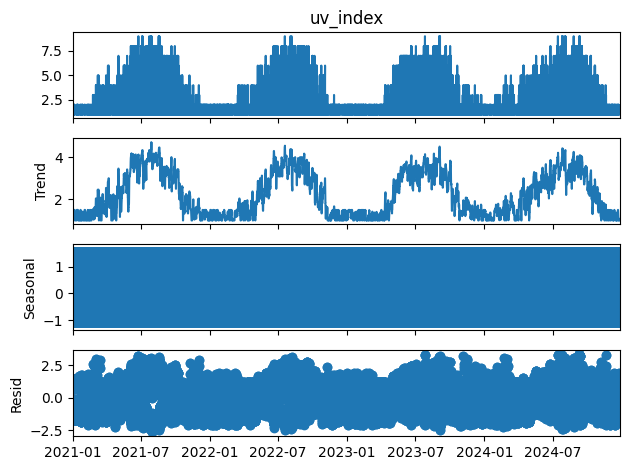

In [21]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Select the uv_index series for the sample location and set datetime as index
uv_series = filtered_df.set_index('datetime')[col].sort_index()

# Decompose the time series assuming daily seasonality (48 half-hour intervals per day)
decomposition = seasonal_decompose(uv_series, model='additive', period=48)

# Plot the observed, trend, seasonal, and residual components
plt.figure(figsize=(12, 8))
decomposition.plot()
plt.tight_layout()
plt.show()

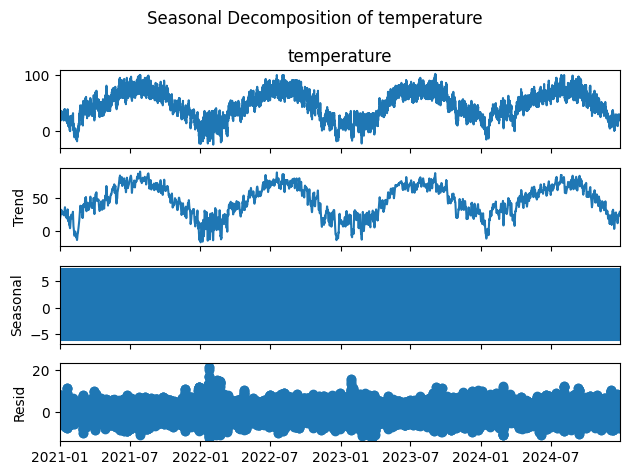

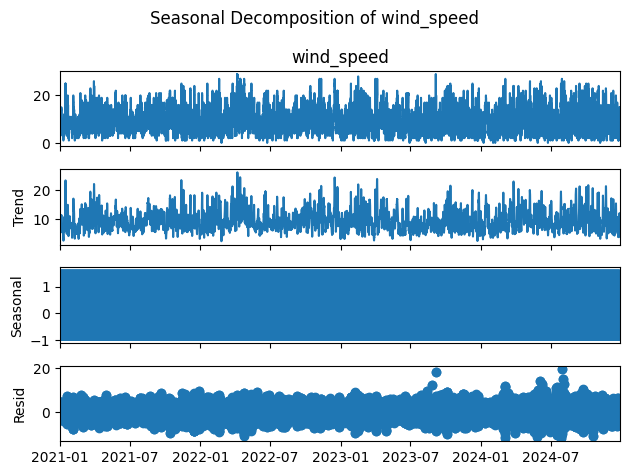

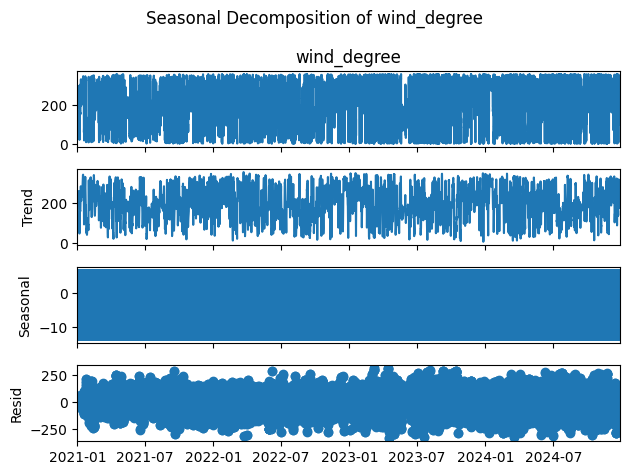

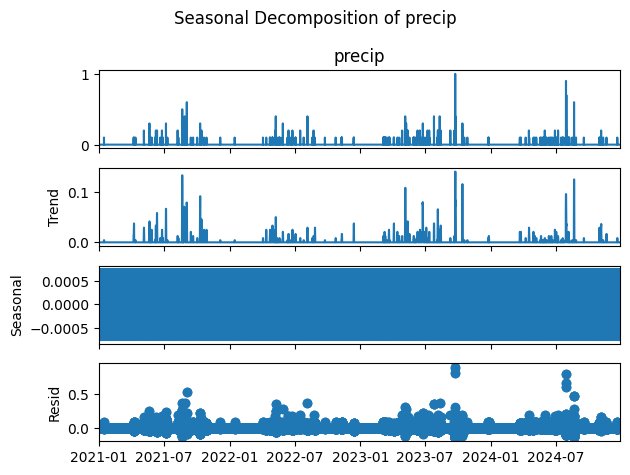

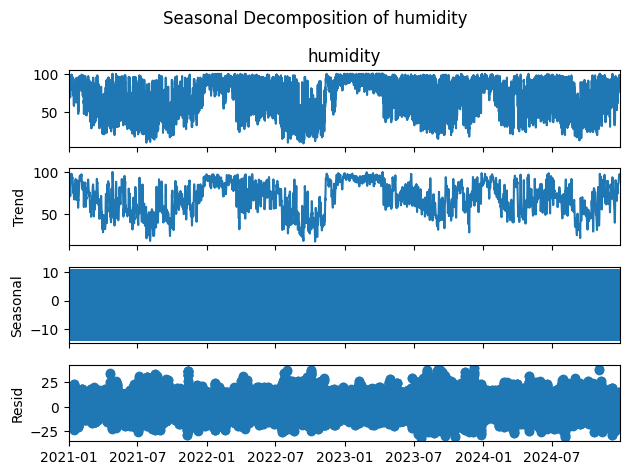

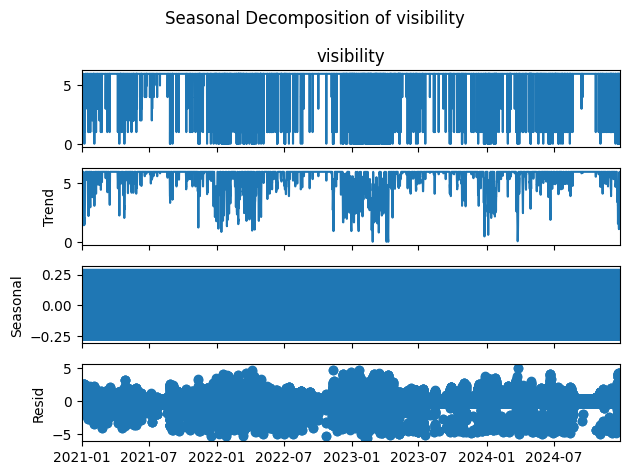

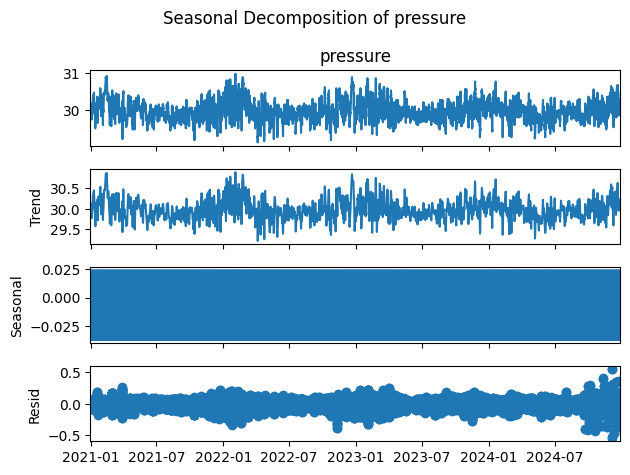

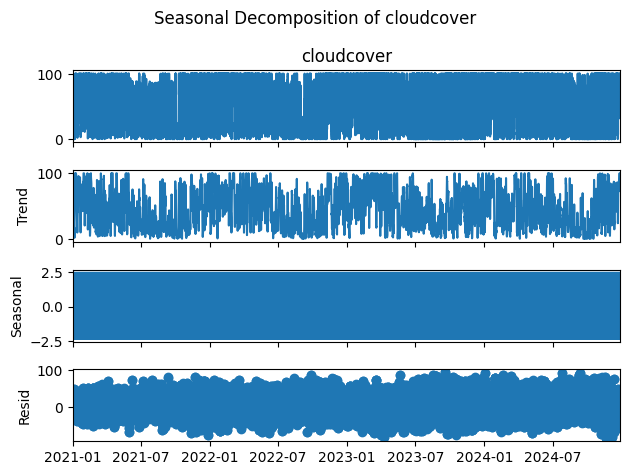

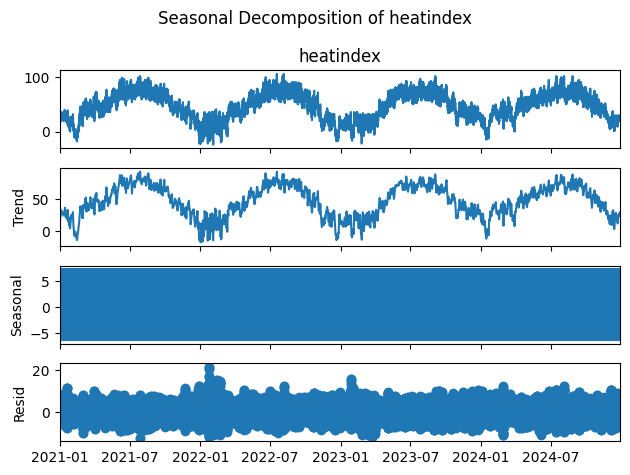

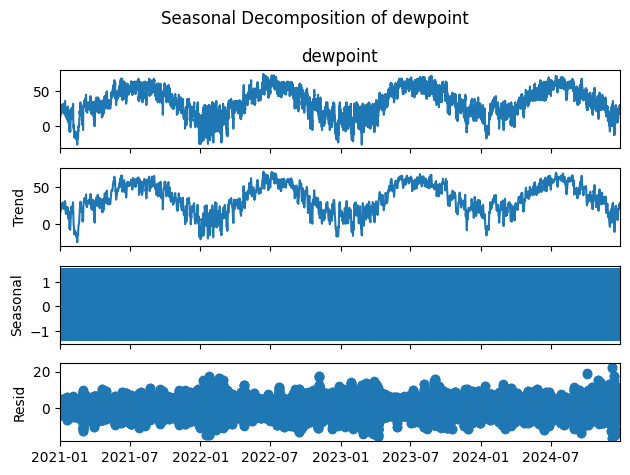

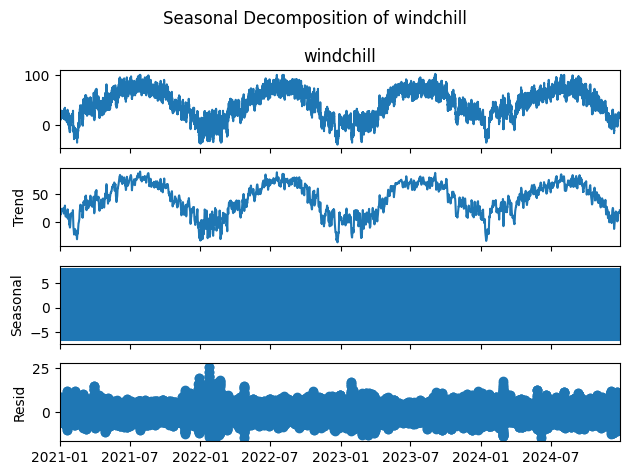

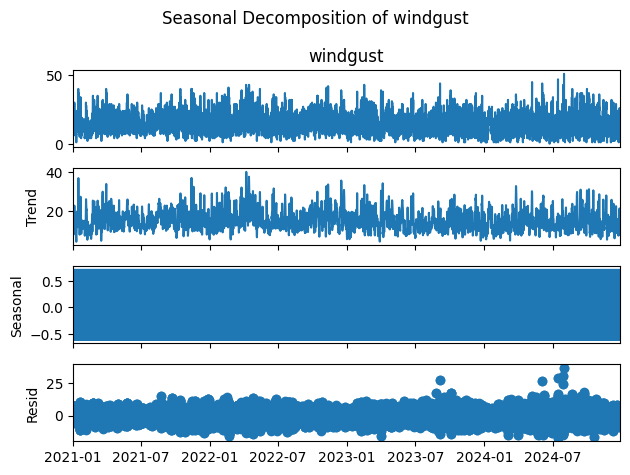

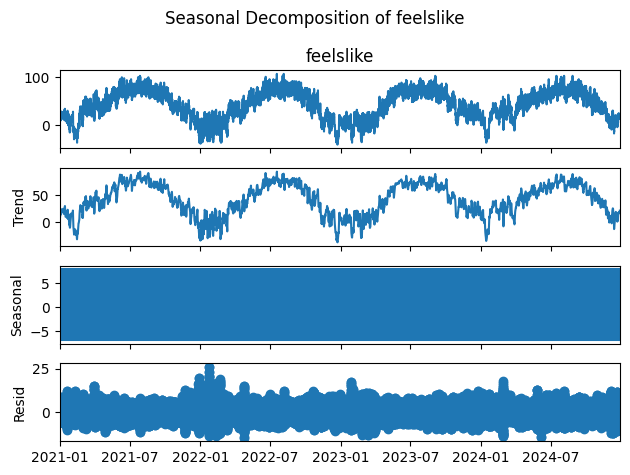

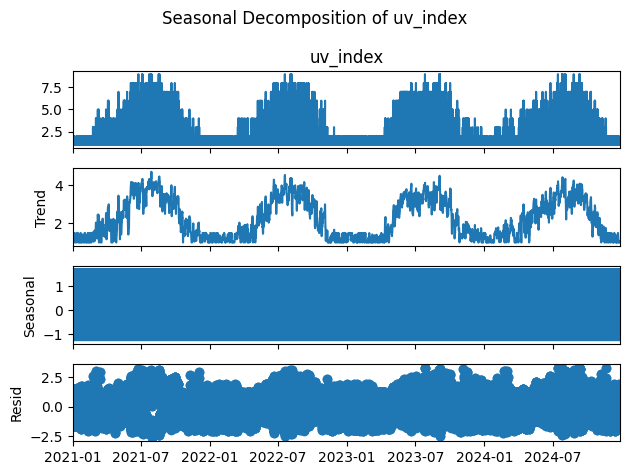

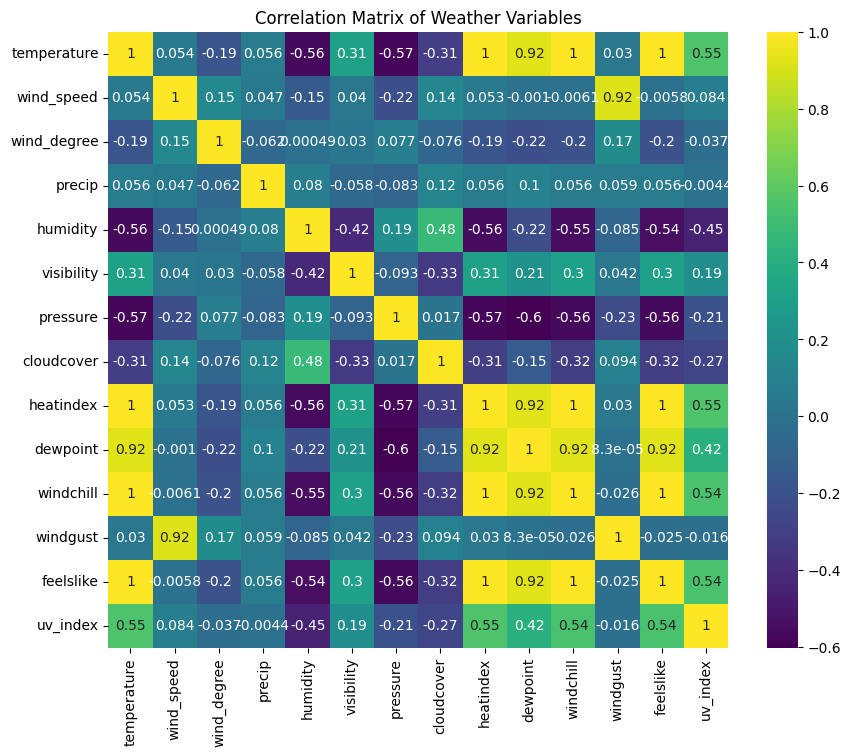

In [22]:
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings

warnings.filterwarnings("ignore")

# Option 1: Seasonal decomposition for each numeric variable in filtered_df (for location_filter)
for var in num_cols:
    series = filtered_df.set_index('datetime')[var].sort_index()
    try:
        result = seasonal_decompose(series, model='additive', period=48)
        fig = result.plot()
        fig.suptitle(f"Seasonal Decomposition of {var}")
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Skipping {var}: {e}")

# Option 2: Compare all numeric variables with a correlation matrix
corr_matrix = filtered_df[num_cols].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='viridis')
plt.title("Correlation Matrix of Weather Variables")
plt.show()

• We successfully parsed and normalized the JSON data, converting all relevant numeric columns (e.g., temperature) to float.

• The timestamps were confirmed to follow the expected 30-minute interval frequency, with no duplicate records found.

• The upsampling procedure maintained consistent date ranges across locations.

• The correlation matrix reveals strong correlations between temperature, heat index, windchill, and feelslike, suggesting these may capture similar weather characteristics, while variables such as uv_index show more moderate correlations with others.

• A seasonal decomposition on the uv_index series provided further insights into its trend and seasonal behavior over time.

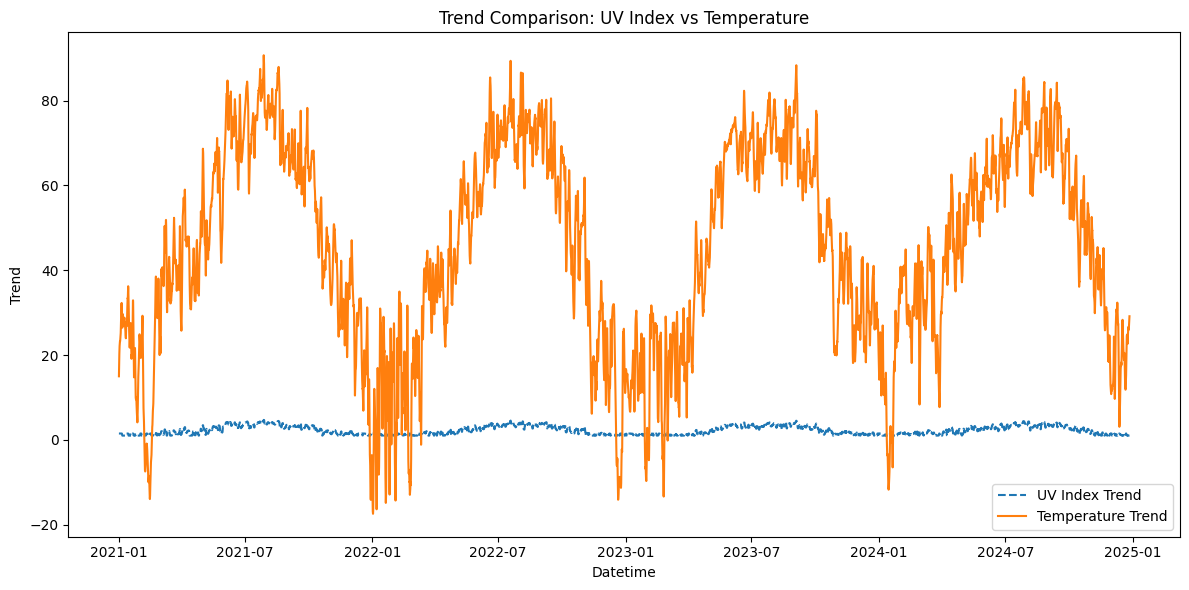

In [23]:
# Extract time series for uv_index and temperature from filtered_df
ts_uv = filtered_df.set_index('datetime')[col].sort_index()
ts_temp = filtered_df.set_index('datetime')['temperature'].sort_index()

# Perform seasonal decomposition with daily seasonality (48 half-hour intervals)
decomp_uv = seasonal_decompose(ts_uv, model='additive', period=48)
decomp_temp = seasonal_decompose(ts_temp, model='additive', period=48)

# Plot the trend components side by side for comparison
plt.figure(figsize=(12,6))
plt.plot(decomp_uv.trend, label="UV Index Trend", linestyle="--")
plt.plot(decomp_temp.trend, label="Temperature Trend", linestyle="-")
plt.legend()
plt.title("Trend Comparison: UV Index vs Temperature")
plt.xlabel("Datetime")
plt.ylabel("Trend")
plt.tight_layout()
plt.show()

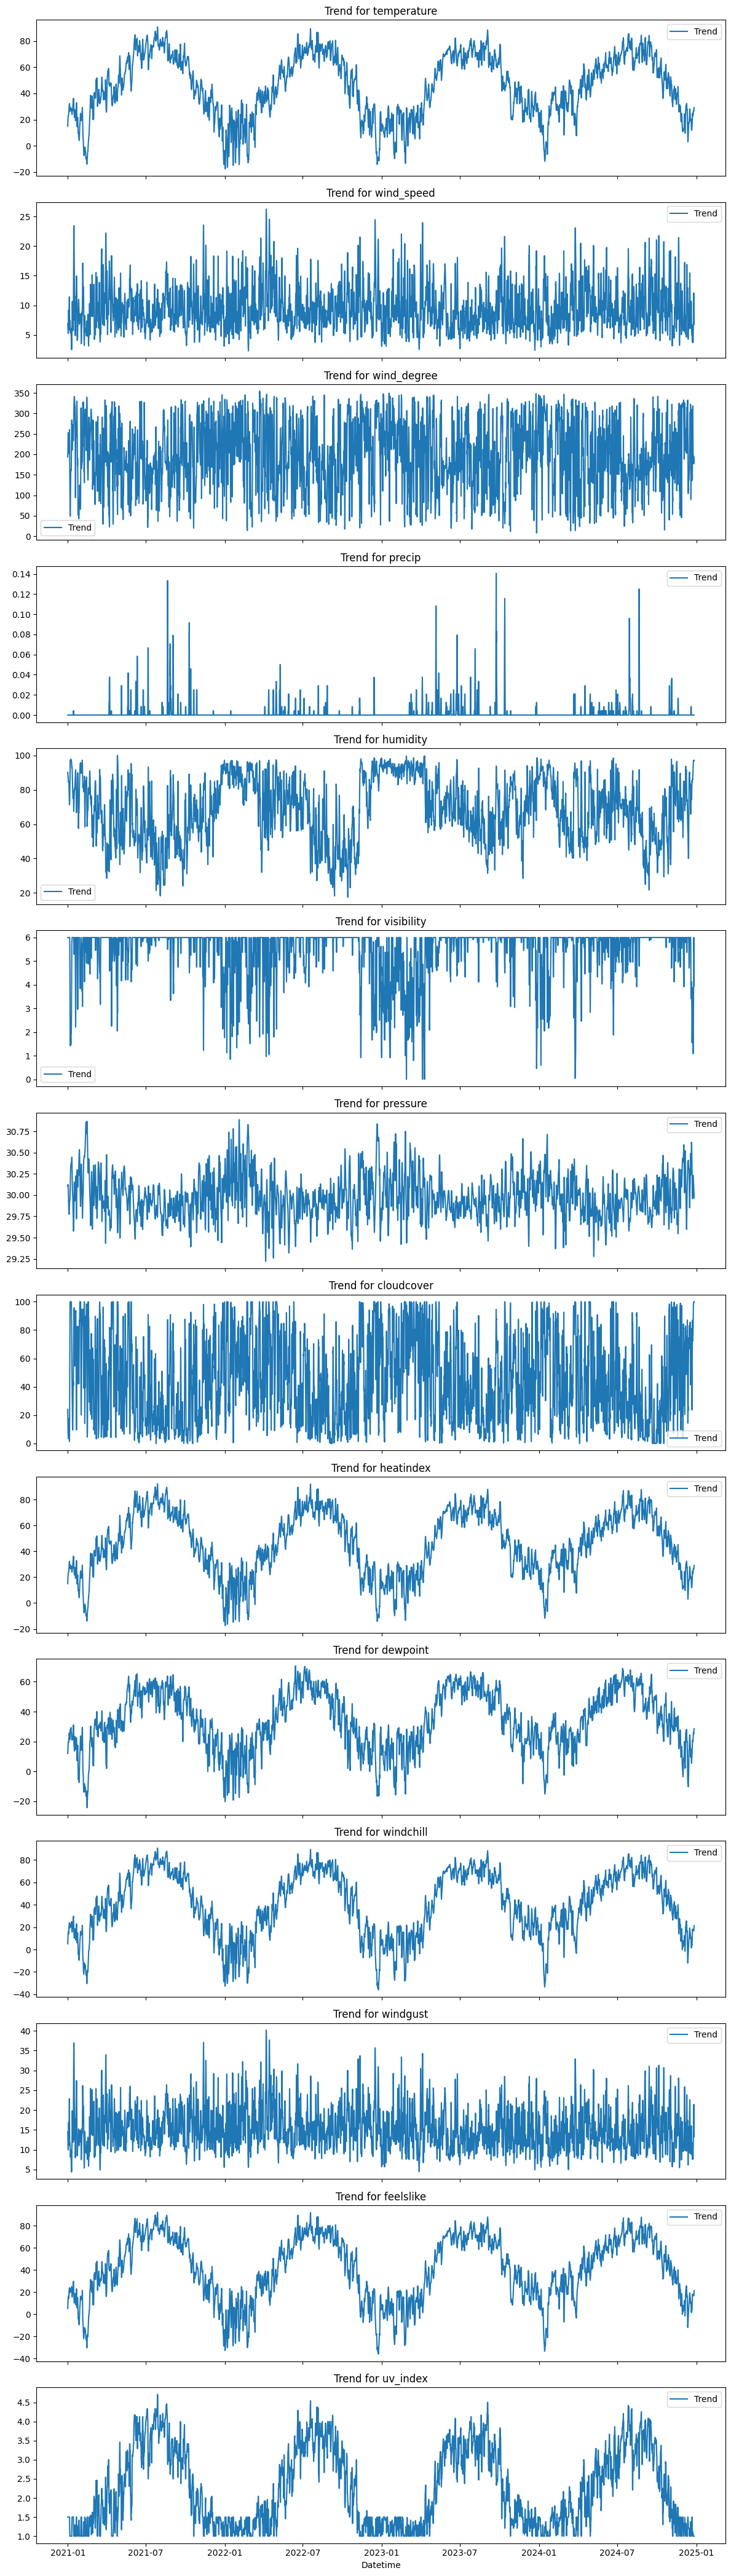

In [24]:
# Plot trend components for all numeric variables from filtered_df using seasonal_decompose
n_vars = len(num_cols)
fig, axes = plt.subplots(nrows=n_vars, figsize=(12, 3 * n_vars), sharex=True)

for i, var in enumerate(num_cols):
    series = filtered_df.set_index('datetime')[var].sort_index()
    try:
        decomp = seasonal_decompose(series, model='additive', period=48)
        axes[i].plot(decomp.trend, label='Trend', color='tab:blue')
        axes[i].set_title(f"Trend for {var}")
        axes[i].legend()
    except Exception as e:
        axes[i].text(0.5, 0.5, f"Error for {var}: {e}", ha='center', va='center')
        axes[i].set_title(f"Trend for {var}")

plt.xlabel("Datetime")
plt.tight_layout()
plt.show()

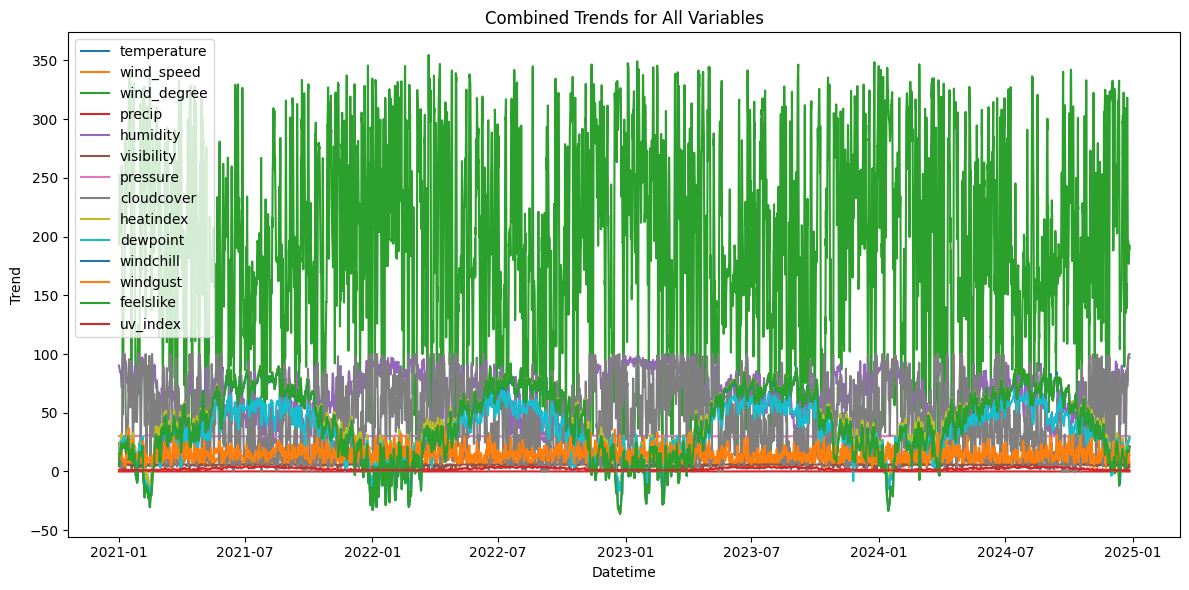

In [25]:
plt.figure(figsize=(12,6))
for var in num_cols:
    ts = filtered_df.set_index('datetime')[var].sort_index()
    try:
        decomp = seasonal_decompose(ts, model='additive', period=48)
        plt.plot(decomp.trend, label=var)
    except Exception as e:
        print(f"Skipping {var}: {e}")
plt.title("Combined Trends for All Variables")
plt.xlabel("Datetime")
plt.ylabel("Trend")
plt.legend()
plt.tight_layout()
plt.show()

The combined trends show that while many weather variables display similar seasonal and long‐term behaviors (for example, temperature, heatindex, windchill, and feelslike often follow similar trends), others such as wind_speed, wind_degree, precip, and humidity exhibit distinct trend patterns. This indicates strong correlations among temperature-related measures and unique trends for variables affected by other atmospheric factors.

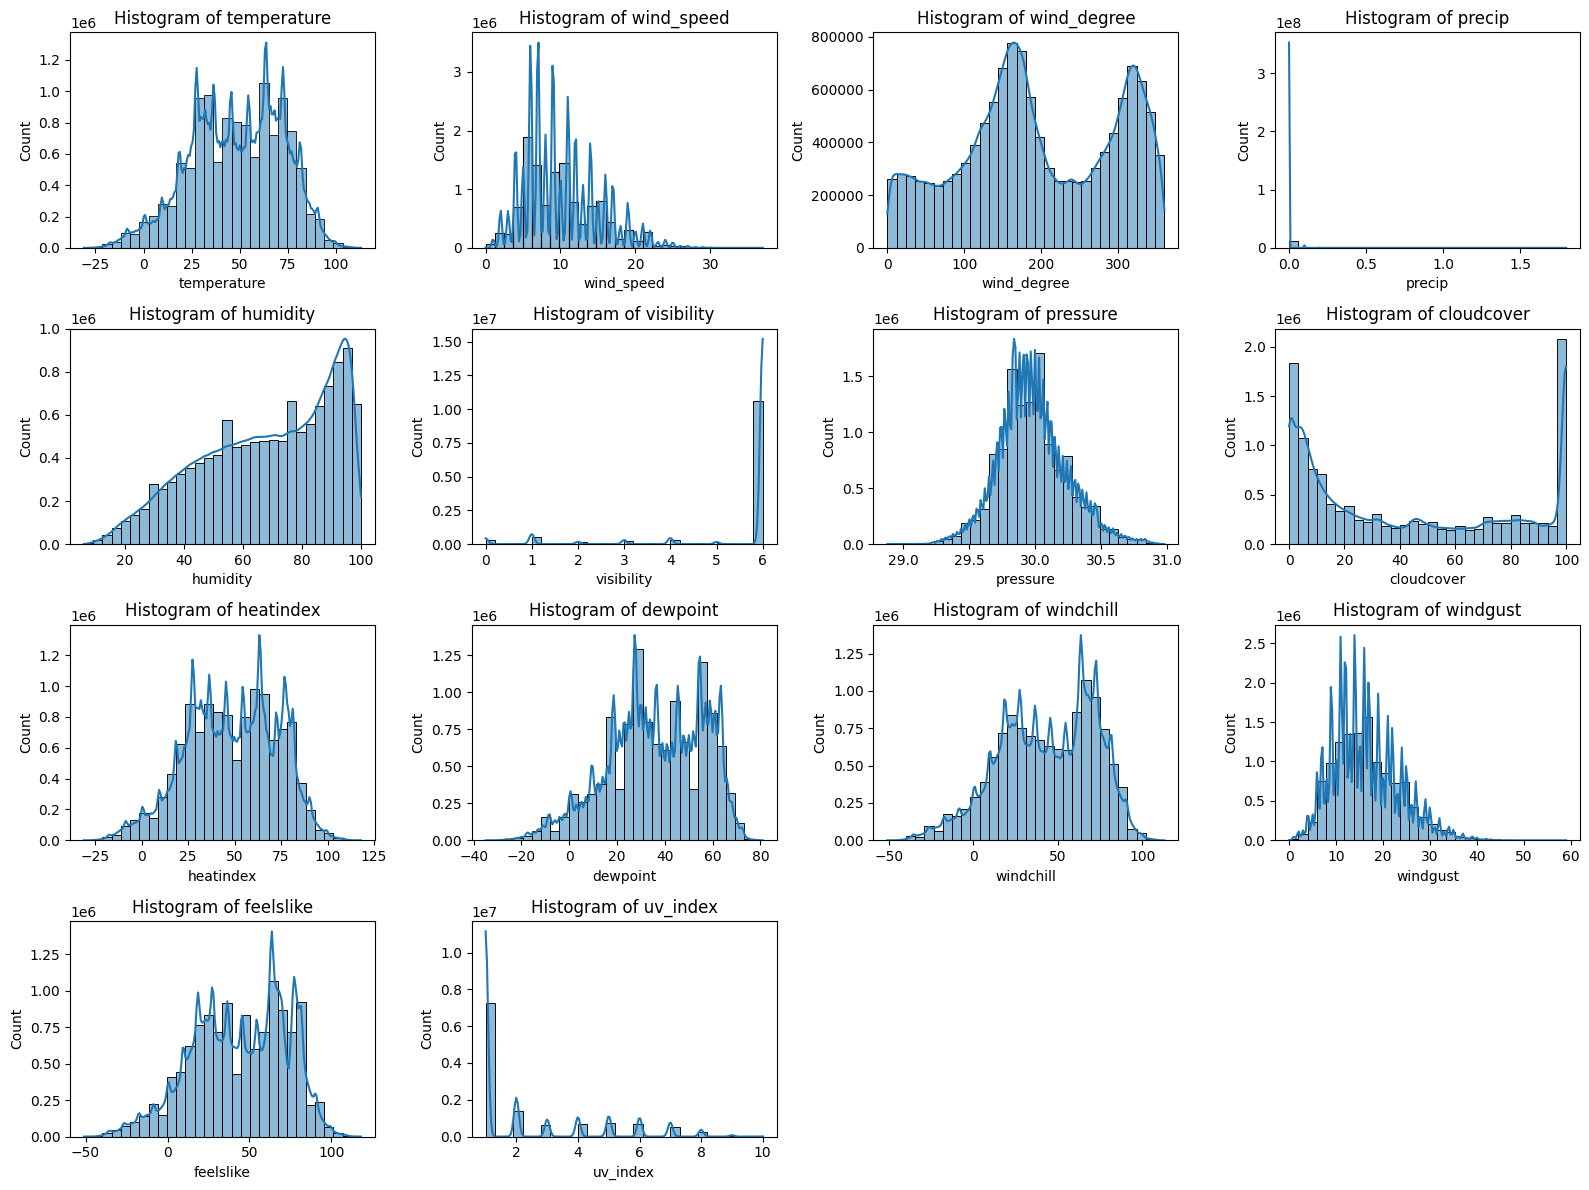

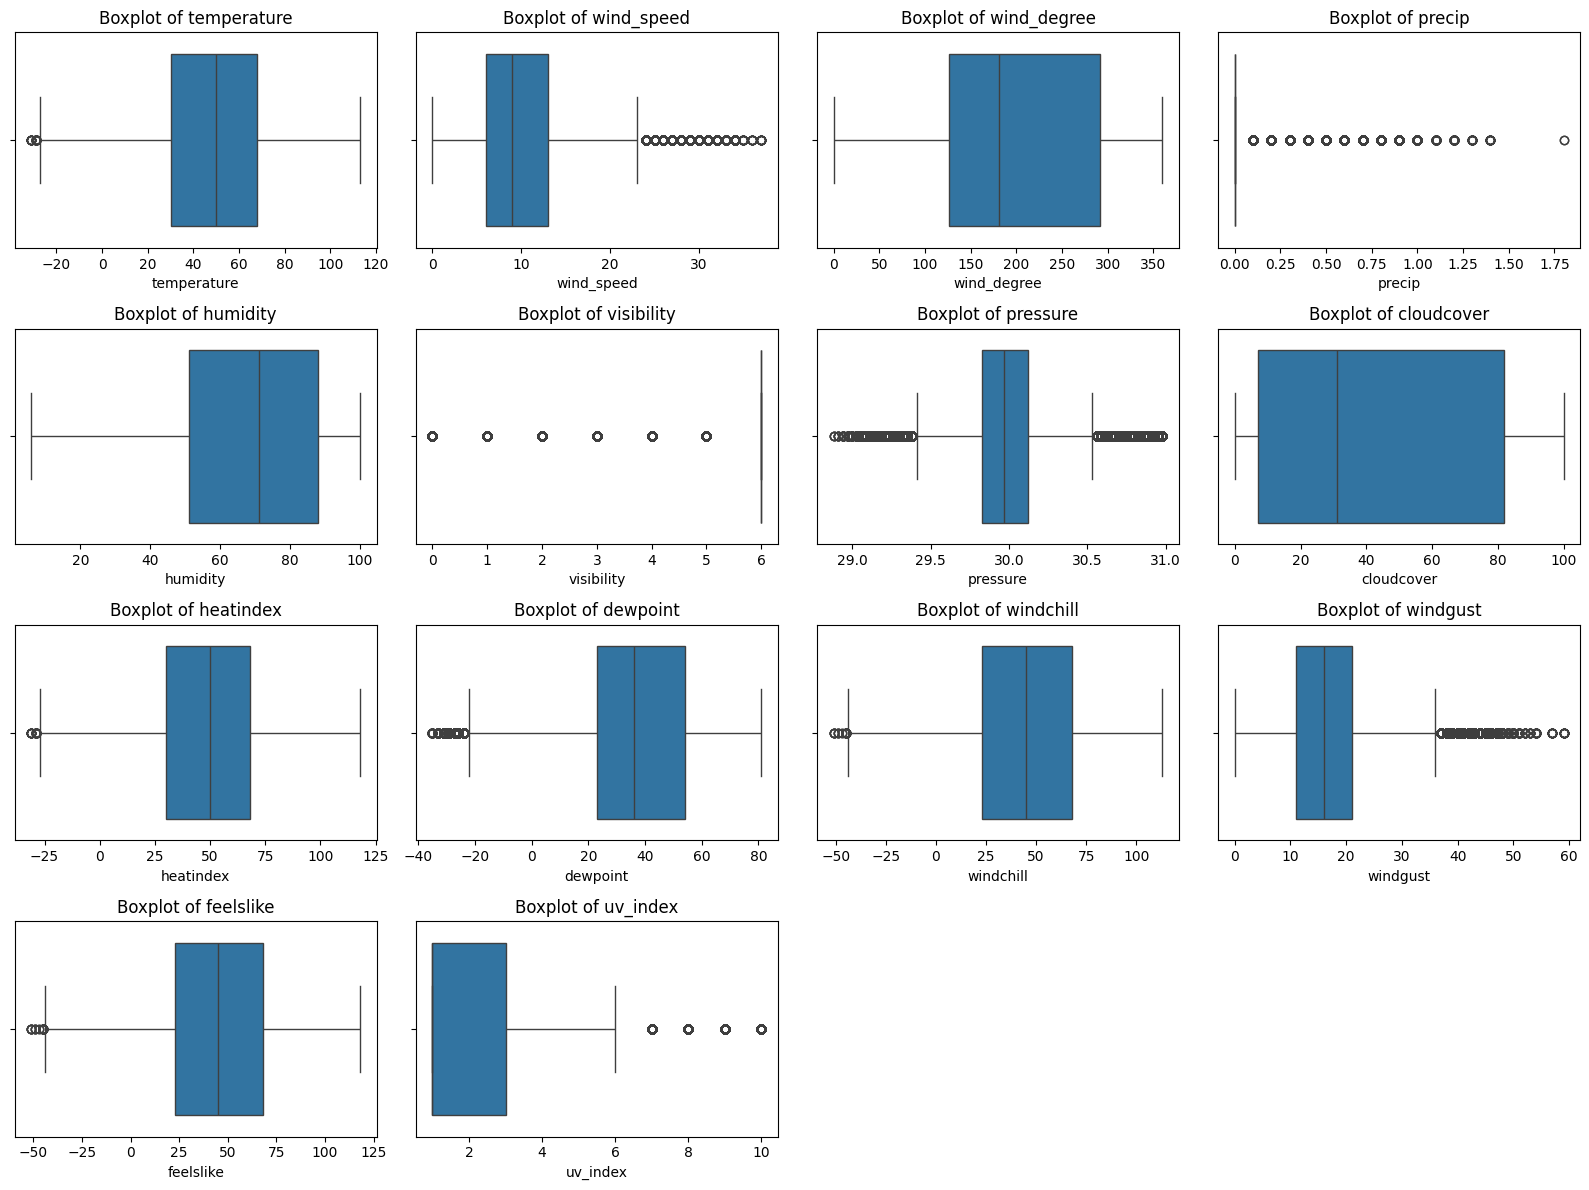

In [26]:
# Analyze the distribution of numeric variables with histograms
plt.figure(figsize=(16, 12))
for i, col in enumerate(num_cols):
    plt.subplot(4, 4, i+1)
    sns.histplot(df_parsed[col].dropna(), kde=True, bins=30)
    plt.title(f'Histogram of {col}')
    plt.tight_layout()
plt.show()

# Analyze outliers using boxplots for numeric variables
plt.figure(figsize=(16, 12))
for i, col in enumerate(num_cols):
    plt.subplot(4, 4, i+1)
    sns.boxplot(x=df_parsed[col].dropna())
    plt.title(f'Boxplot of {col}')
    plt.tight_layout()
plt.show()

Next steps are to query Open-Mateo by date range and variable to suppliement the dataset with percipitation data. 

In [36]:
output_file = r'processed_weather.json'
df_parsed.to_json(output_file, orient='records', date_format='iso')
print(f"Updated dataframe saved to {output_file}")

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x000002295E497D90>>
Traceback (most recent call last):
  File "C:\Users\Linds\AppData\Roaming\Python\Python311\site-packages\ipykernel\ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


Updated dataframe saved to updated_dataset.json


In [1]:
!jupyter nbconvert --to pdf "all_hist_weather.ipynb"

[NbConvertApp] Converting notebook all_hist_weather.ipynb to pdf
[NbConvertApp] Support files will be in all_hist_weather_files\
[NbConvertApp] Making directory .\all_hist_weather_files
[NbConvertApp] Writing 82032 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | b had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 2543445 bytes to all_hist_weather.pdf


# Brief Insights from Weather Data Analysis

- Weather data was successfully parsed and normalized from JSON, with numeric values properly converted to floats.
- Timestamps were verified to follow the expected 30-minute interval, ensuring consistency in the series.
- The upsampling and forward-fill process maintained consistent date ranges across various locations.
- Analysis of duplicate entries and missing values confirmed well-maintained data integrity.
- Strong correlations were observed among temperature, heat index, windchill, and feelslike, highlighting similar underlying patterns.
- Seasonal decomposition of uv_index and temperature revealed clear trends and daily seasonal cycles.
- Distribution analyses (histograms and boxplots) provided insights into data spread and potential outliers.
- The absence of precipitation data was identified, prompting plans to supplement the dataset via the Open-Meteo API.
- Overall, these insights support the project goals of reliable weather data analysis and accurate identification of seasonal/trend patterns.

# Key Insights from Weather Data Analysis

- **Data Parsing & Normalization:**  
    The JSON weather data was successfully parsed and normalized with numeric fields (like temperature) properly converted to floats.

- **Timestamp Integrity:**  
    Timestamps were verified to follow the expected 30-minute frequency with no duplicate records, ensuring a consistent time series.

- **Upsampling Effects:**  
    The upsampling process using half-hour intervals maintained consistent date ranges across locations, with forward-filling ensuring no missing values.

- **Data Integrity Checks:**  
    Analyses, including duplicate row detection and missing value counts, confirmed that the data integrity was well maintained.

- **Correlation Insights:**  
    Strong correlations were observed between temperature-related measures (temperature, heat index, windchill, feelslike), indicating redundancy among these variables.

- **Seasonal & Trend Analysis:**  
    Seasonal decomposition on variables like uv_index and temperature revealed clear trends and daily cycles, reflecting underlying weather patterns.

- **Distribution & Outlier Analysis:**  
    Histograms and boxplots provided a visual understanding of the data distributions and potential outliers.

- **Precipitation Data Gap:**  
    The analysis also identified a lack of precipitation data, prompting plans to supplement the dataset via an external API.